<a href="https://colab.research.google.com/github/blakzaei/GAN-on-tf_flowers/blob/master/GAN_tf_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#-- Install Required Libraries -------------------------------------------------
!pip install numpy2tfrecord
!pip install Albumentations
!pip install tensorboardX
#-------------------------------------------------------------------------------

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#-- Imports --------------------------------------------------------------------
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers
from keras import optimizers 
from keras.models import Model , Sequential
from keras.initializers import RandomNormal
from keras.utils import plot_model
from keras.callbacks import TensorBoard

from tensorboardX import SummaryWriter

import albumentations as A

from numpy2tfrecord import Numpy2TFRecordConverter

from functools import partial

import numpy as np
import random
import datetime

import matplotlib.pyplot as plt
from IPython.display import Image
#-------------------------------------------------------------------------------

In [ ]:
#-- Initialising Parameters ----------------------------------------------------

np.random.seed(10)  
NOISE_VEC_DIM = 100  

IMG_ROW, IMG_COL, IMG_CHANNEL = 64, 64, 3

BATCH_SIZE = 128
STEPS_PER_EPOCH = 50
EPOCHS = 150

OPTIMIZER = optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)

FILTER_SIZE = 5
N_FILTERS= 64
DROPOUT_PROB = 0.5
SCALE = 0.2
INPUT_SIZE = [IMG_ROW, IMG_COL, IMG_CHANNEL]
#-------------------------------------------------------------------------------

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#-- Load DS --------------------------------------------------------------------
ds, ds_info = tfds.load(
    'tf_flowers',    
    with_info=True,
    as_supervised=True,
)

training_set = ds['train']
#-------------------------------------------------------------------------------

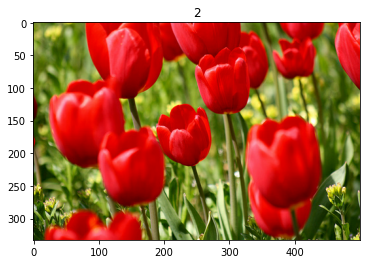

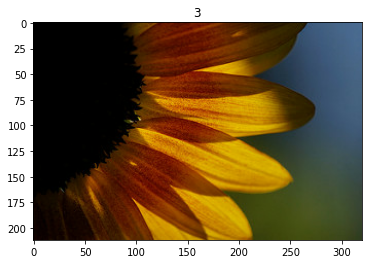

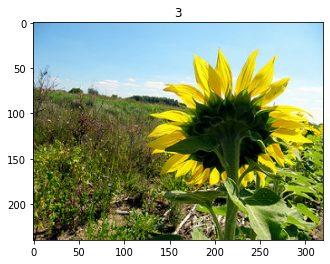

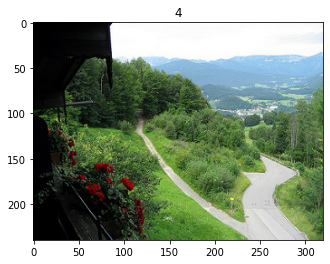

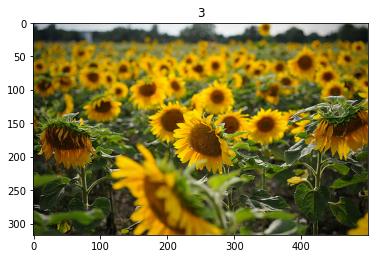

In [ ]:
#-- Plot a few Frist Images ----------------------------------------------------
for image, label in training_set.take(5):
  image = image.numpy()
  plt.figure()
  plt.title(int(label))  
  plt.imshow(image, cmap=plt.cm.binary)
  plt.show()
#-------------------------------------------------------------------------------

In [ ]:
#-- Extract Images from DS -----------------------------------------------------
images = []
for image, label in training_set.take(-1):
  images.append(image.numpy())

print(len(images))
#-------------------------------------------------------------------------------

3670


In [ ]:
#-- Image Augmentation ---------------------------------------------------------
#-- list of augmentations --
transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.5, rotate_limit=5, p=.8),
    A.Blur(blur_limit=7),
    A.GridDistortion(),
])

#-- Run a Maximum of 3 Augmentations on each Image --
augmented_images = images.copy()
max_aug = 3
for img in images:  
  n_aug = random.randint(1, max_aug)
  for i in range(n_aug):
    aug_img = transform(image=img)['image']
    augmented_images.append(aug_img)

print(len(augmented_images))
#-------------------------------------------------------------------------------

10971


In [ ]:
#-- Show Images Size -----------------------------------------------------------
for i in range(5):
  print('Image {} shape: {} '.format(i+1, images[i].shape))
#-------------------------------------------------------------------------------

Image 1 shape: (333, 500, 3) 
Image 2 shape: (212, 320, 3) 
Image 3 shape: (240, 320, 3) 
Image 4 shape: (240, 320, 3) 
Image 5 shape: (317, 500, 3) 


In [ ]:
#-- Resize Image ---------------------------------------------------------------
def Resize_Image(image):
  image = tf.image.resize(image, (IMG_ROW, IMG_COL))/255.0
  return image
#-------------------------------------------------------------------------------

#-- Resize All Images --
training_images = list(map(Resize_Image, augmented_images))

#-- Show Images Size --
for i in range(5):
  print('Image {} shape: {} '.format(i+1, training_images[i].shape))
#-------------------------------------------------------------------------------

Image 1 shape: (64, 64, 3) 
Image 2 shape: (64, 64, 3) 
Image 3 shape: (64, 64, 3) 
Image 4 shape: (64, 64, 3) 
Image 5 shape: (64, 64, 3) 


In [ ]:
#-- Save Images as tfrecord ----------------------------------------------------
#-- Set path and file name --
path_tfrecords = 'images.tfrecords'

#-- convert all images to tfrecords --
samples = []
with Numpy2TFRecordConverter(path_tfrecords) as converter:
  for img in training_images:
    img = img.numpy()
    img = img.astype(np.float32)
    sample = {"img": img}
    samples .append(sample)
    
  converter.convert_list(samples)
#-------------------------------------------------------------------------------

In [ ]:
#-- Read each tfrecord and decode it to an image -------------------------------
def Read_tfrecord(sample):
    tfrecord_format = (
         {'img': tf.io.FixedLenFeature([IMG_ROW,IMG_COL,IMG_CHANNEL], tf.float32),}
    )
    sample = tf.io.parse_single_example(sample, tfrecord_format)   
    image = sample['img']   
    
    return image
#-------------------------------------------------------------------------------

In [ ]:
#-- Load DS from tfrecords file ------------------------------------------------
def Load_Dataset(filename):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  
    
    dataset = tf.data.TFRecordDataset(filename)  
    dataset = dataset.with_options(ignore_order)    
    dataset = dataset.map(partial(Read_tfrecord))  
    
    return dataset
#-------------------------------------------------------------------------------

In [ ]:
#-- Load DS from tfrecords and Save as Numpy Array -----------------------------
dataset = Load_Dataset(path_tfrecords)
print(type(dataset))

ds_size = len(list(dataset))

X_train  = np.zeros((ds_size,IMG_ROW,IMG_COL,IMG_CHANNEL))

index = 0
for image in dataset.take(-1):  
  X_train[index] = image
  index += 1

np.random.shuffle(X_train)
print(X_train.shape)
#-------------------------------------------------------------------------------

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
(10971, 64, 64, 3)


In [ ]:
#-- Generator 1 ----------------------------------------------------------------
def Create_Generator_1():

    generator = Sequential()        
    #------------------------------------------------------
    
    d = 4
    generator.add(layers.Dense(d*d*512,
                               input_shape=(NOISE_VEC_DIM,),
                               name='gen_Dense')) 
    print(generator.input_shape)    
    #------------------------------------------------------

    generator.add(layers.Reshape((d, d, 512),
                                 name='gen_Reshape'))
    print(generator.output_shape)
    #------------------------------------------------------ 

    generator.add(layers.Conv2DTranspose(4*N_FILTERS,
                                         (FILTER_SIZE, FILTER_SIZE),
                                         name='gen_Con2DTrans_1'))   
    generator.add(layers.BatchNormalization(name='gen_BatchNorm_1'))
    generator.add(layers.LeakyReLU(name='gen_LRelU_1'))
    print(generator.output_shape)
    #------------------------------------------------------  

    generator.add(layers.Conv2DTranspose(2*N_FILTERS,
                                         (FILTER_SIZE, FILTER_SIZE),
                                         strides=(2, 2),
                                         padding='same',
                                         name='gen_Con2DTrans_2'))  
    generator.add(layers.BatchNormalization(name='gen_BatchNorm_2'))
    generator.add(layers.LeakyReLU(name='gen_LRelU_2'))
    print(generator.output_shape)
    #------------------------------------------------------  

    generator.add(layers.Conv2DTranspose(N_FILTERS,
                                         (FILTER_SIZE, FILTER_SIZE),
                                         strides=(2, 2),
                                         padding='same',
                                         name='gen_Con2DTrans_3'))   
    generator.add(layers.BatchNormalization(name='gen_BatchNorm_3'))
    generator.add(layers.LeakyReLU(name='gen_LRelU_3'))
    print(generator.output_shape)

    #------------------------------------------------------

    generator.add(layers.Conv2DTranspose(3,
                                         (FILTER_SIZE, FILTER_SIZE),
                                         strides=(2, 2),
                                         padding='same',
                                         activation='tanh',
                                         name='gen_Con2DTrans_4'))  
    print(generator.output_shape)
    #------------------------------------------------------  
        
    generator.compile(loss='binary_crossentropy', optimizer=OPTIMIZER)      
    #------------------------------------------------------
    
    return generator
#-------------------------------------------------------------------------------

In [ ]:
#-- Discriminator 1 ------------------------------------------------------------
def Create_Discriminator_1():
    discriminator = Sequential()    
    #-----------------------------------------------------------

    discriminator.add(layers.InputLayer(input_shape=INPUT_SIZE,
                                        name = 'disc_Input'))
    discriminator.add(layers.Dropout(DROPOUT_PROB,
                                     name= 'disc_Dropout_1'))
    print(discriminator.output_shape)
    #-----------------------------------------------------------

    discriminator.add(layers.Conv2D(N_FILTERS,
                            (FILTER_SIZE, FILTER_SIZE),
                            strides=(2, 2),
                            padding='same',
                            name='disc_Conv_1'))
    discriminator.add(layers.LeakyReLU(SCALE,
                                       name = 'disc_LRelU_1'))    
    print(discriminator.output_shape)
    #-----------------------------------------------------------

    discriminator.add(layers.Conv2D(2*N_FILTERS,
                            (FILTER_SIZE, FILTER_SIZE),
                            strides=(2, 2),
                            padding='same',
                            name='disc_Conv_2'))
    discriminator.add(layers.BatchNormalization(name='BatchNorm_2'))
    discriminator.add(layers.LeakyReLU(SCALE,
                                       name = 'disc_LRelU_2'))
    print(discriminator.output_shape)
    #-----------------------------------------------------------

    discriminator.add(layers.Conv2D(4*N_FILTERS,
                            (FILTER_SIZE, FILTER_SIZE),
                            strides=(2, 2),
                            padding='same',
                            name='disc_Conv_3'))
    discriminator.add(layers.BatchNormalization(name='BatchNorm_3'))
    discriminator.add(layers.LeakyReLU(SCALE,
                                       name = 'disc_LRelU_3'))
    print(discriminator.output_shape)
    #-----------------------------------------------------------

    discriminator.add(layers.Conv2D(8*N_FILTERS,
                            (FILTER_SIZE, FILTER_SIZE),
                            strides=(2, 2),
                            padding='same',
                            name='disc_Conv_4'))
    discriminator.add(layers.BatchNormalization(name='BatchNorm_4'))
    discriminator.add(layers.LeakyReLU(SCALE,
                                       name = 'disc_LRelU_4'))
    print(discriminator.output_shape)
    #-----------------------------------------------------------

    discriminator.add(layers.Flatten(name='disc_Flatten'))
    discriminator.add(layers.Dropout(0.4, name='disc_Dropout'))
    
    discriminator.add(layers.Dense(1,
                                   activation='sigmoid',
                                   input_shape=(IMG_COL, IMG_ROW, IMG_CHANNEL),
                                   name='disc_Output_2'))
    #-----------------------------------------------------------
    
    discriminator.compile(loss='binary_crossentropy', optimizer=OPTIMIZER) 
    #----------------------------------------------------------- 
    
    return discriminator
#-------------------------------------------------------------------------------

In [ ]:
#-- Generator 2 ----------------------------------------------------------------
def Create_Generator_2():
    generator = Sequential()    
    #----------------------------------------------------

    d = 16
    generator.add(layers.Dense(d*d*256,
                               kernel_initializer=RandomNormal(0, 0.02),
                               input_dim=NOISE_VEC_DIM,
                               name = 'gen_dense'))
    generator.add(layers.LeakyReLU(0.2,
                                   name = 'gen_LRelU_0'))   
    print(generator.input_shape) 
    #----------------------------------------------------

    generator.add(layers.Reshape((d, d, 256),
                                 name='gen_Reshape'))
    print(generator.output_shape)
    #----------------------------------------------------
    
    generator.add(layers.Conv2DTranspose(128, (4, 4),
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=RandomNormal(0, 0.02),
                                         name = 'gen_Con2DTrans_1'))
    generator.add(layers.LeakyReLU(0.2,
                                   name = 'gen_LRelU_1'))
    print(generator.output_shape)
    #----------------------------------------------------

    generator.add(layers.Conv2DTranspose(128, (4, 4),
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=RandomNormal(0, 0.02),
                                         name = 'gen_Con2DTrans_2'))
    generator.add(layers.LeakyReLU(0.2,
                                   name = 'gen_LRelU_2'))
    print(generator.output_shape)
    #----------------------------------------------------
    
    generator.add(layers.Conv2D(IMG_CHANNEL, (3, 3),
                                padding='same',
                                activation='tanh',
                                kernel_initializer=RandomNormal(0, 0.02),
                                name = 'gen_Con2DTrans_3')) 
    print(generator.output_shape)
    #----------------------------------------------------

    generator.compile(loss='binary_crossentropy', optimizer=OPTIMIZER)      
    #---------------------------------------------------- 
    
    return generator
#-------------------------------------------------------------------------------

In [ ]:
#-- Discriminator 2 ------------------------------------------------------------
def Create_Discriminator_2():

    discriminator = Sequential()
    #----------------------------------------------------
    
    discriminator.add(layers.Conv2D(64,
                                    (3, 3),
                                    padding='same',
                                    kernel_initializer=RandomNormal(0, 0.02),
                                    input_shape=(IMG_COL, IMG_ROW, IMG_CHANNEL),
                                    name= 'disc_Conv_1'))
    discriminator.add(layers.LeakyReLU(0.2,
                                       name='disc_LRelU_1'))
    print(discriminator.output_shape)
    #----------------------------------------------------
    
    discriminator.add(layers.Conv2D(128,
                                    (3, 3),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=RandomNormal(0, 0.02),
                                    name= 'disc_Conv_2'))
    discriminator.add(layers.LeakyReLU(0.2,
                                       name='disc_LRelU_2'))
    print(discriminator.output_shape)
    #----------------------------------------------------
    
    discriminator.add(layers.Conv2D(128,
                                    (3, 3),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=RandomNormal(0, 0.02),
                                    name= 'disc_Conv_3'))
    discriminator.add(layers.LeakyReLU(0.2,
                                       name='disc_LRelU_3'))
    print(discriminator.output_shape)
    #----------------------------------------------------
    
    discriminator.add(layers.Conv2D(256,
                                    (3, 3),
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=RandomNormal(0, 0.02),
                                    name= 'disc_Conv_4'))
    discriminator.add(layers.LeakyReLU(0.2,
                                       name='disc_LRelU_4'))
    print(discriminator.output_shape)
    #----------------------------------------------------
    
    discriminator.add(layers.Flatten(name='disc_Flatten'))
    discriminator.add(layers.Dropout(0.4,
                                     name = 'disc_Dropout'))
    print(discriminator.output_shape)
    #----------------------------------------------------
    
    discriminator.add(layers.Dense(1,
                                   activation='sigmoid',
                                   input_shape=(IMG_COL, IMG_ROW, IMG_CHANNEL),
                                   name = 'disc_Output'))
    print(discriminator.output_shape)
    #----------------------------------------------------
    
    discriminator.compile(loss='binary_crossentropy', optimizer=OPTIMIZER)  
    #----------------------------------------------------

    return discriminator

In [ ]:
#-- Create GAN-----------------------------------------------------------------
def Create_GAN(discriminator , generator):           

    discriminator.trainable = False          

    gan_input = layers.Input(shape=(NOISE_VEC_DIM,), name='gan_Input')    
    fake_image = generator(gan_input)        

    gan_output = discriminator(fake_image)   

    gan = Model(gan_input, gan_output)       
    
    gan.compile(loss='binary_crossentropy', optimizer=OPTIMIZER)   
    
    return gan
#-------------------------------------------------------------------------------

In [ ]:
#-- Plot Imgages----------------------------------------------------------------
def Plot_Images(noise, size_fig, generator, epoch):

    #-- get generated images by generator --
    generated_images = generator.predict(noise)   

    #-- create a figure --
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if IMG_CHANNEL == 1:
            image = image.reshape((IMG_ROW, IMG_COL))
            plt.imshow(image, cmap='gray')    
        else:
            image = image.reshape((IMG_ROW, IMG_COL, IMG_CHANNEL))
            plt.imshow(image)
        
        Write_Log_Images(image , epoch)

        plt.axis('off')        
    
    plt.tight_layout()   
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()
#-------------------------------------------------------------------------------

In [ ]:
#-- Plot Losses-----------------------------------------------------------------
def Plot_Loss(d_losses, g_losses):
    
    plt.rcParams.update({'font.size': 22})
    
    d_losses = np.round(d_losses , 3)
    g_losses = np.round(g_losses , 3)
    
    x_plot = range(1, len(d_losses)+1)
    
    plt.figure(figsize=(7,4))    
    
    plt.plot(x_plot, d_losses , label= 'discriminator')
    
    plt.plot(x_plot , g_losses, label = 'generator')
    
    
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.grid()
    plt.show()
#-------------------------------------------------------------------------------

In [ ]:
#-- Create GAN Model 1 ---------------------------------------------------------

#-- Create generator --
generator = Create_Generator_1()

#-- Models Summery--generator --
plot_model(generator, show_shapes=True,
                       show_layer_names=True, to_file='generator.png')
Image(retina=True, filename='generator.png')
generator.summary()

#-- Create discriminator --
discriminator = Create_Discriminator_1()

#-- Models Summery--discriminator --
plot_model(discriminator, show_shapes=True,
                       show_layer_names=True, to_file='discriminator.png')
Image(retina=True, filename='discriminator.png')
discriminator.summary()

#-- Create GAN --
gan = Create_GAN(discriminator, generator)

#-- Models Summery--gan --
plot_model(gan, show_shapes=True,
                       show_layer_names=True, to_file='gan.png')
Image(retina=True, filename='gan.png')
gan.summary()
#-------------------------------------------------------------------------------

(None, 100)
(None, 4, 4, 512)
(None, 8, 8, 256)
(None, 16, 16, 128)
(None, 32, 32, 64)
(None, 64, 64, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gen_Dense (Dense)           (None, 8192)              827392    
                                                                 
 gen_Reshape (Reshape)       (None, 4, 4, 512)         0         
                                                                 
 gen_Con2DTrans_1 (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 gen_BatchNorm_1 (BatchNorma  (None, 8, 8, 256)        1024      
 lization)                                                       
                                                                 
 gen_LRelU_1 (LeakyReLU)     (None, 8, 8, 256)         0         
                 

In [ ]:
#-- Create GAN Model 2  --------------------------------------------------------
#-- Create generator --
generator = Create_Generator_2()

#-- Models Summery--generator --
plot_model(generator, show_shapes=True,
                       show_layer_names=True, to_file='generator.png')
Image(retina=True, filename='generator.png')
generator.summary()

#-- Create discriminator --
discriminator = Create_Discriminator_2()

#-- Models Summery--discriminator --
plot_model(discriminator, show_shapes=True,
                       show_layer_names=True, to_file='discriminator.png')
Image(retina=True, filename='discriminator.png')
discriminator.summary()

#-- Create GAN --
gan = Create_GAN(discriminator, generator)

#-- Models Summery--gan --
plot_model(gan, show_shapes=True,
                       show_layer_names=True, to_file='gan.png')
Image(retina=True, filename='gan.png')
gan.summary()
#-------------------------------------------------------------------------------

(None, 100)
(None, 16, 16, 256)
(None, 32, 32, 128)
(None, 64, 64, 128)
(None, 64, 64, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gen_dense (Dense)           (None, 65536)             6619136   
                                                                 
 gen_LRelU_0 (LeakyReLU)     (None, 65536)             0         
                                                                 
 gen_Reshape (Reshape)       (None, 16, 16, 256)       0         
                                                                 
 gen_Con2DTrans_1 (Conv2DTra  (None, 32, 32, 128)      524416    
 nspose)                                                         
                                                                 
 gen_LRelU_1 (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 gen_Con2DTrans_2 (Conv2DTra  

In [ ]:
#-- Tensorboard ----------------------------------------------------------------
#-- load tensorboard --
%load_ext tensorboard

log_path = '/tmp/my_logs'

#-- Clear any logs from previous runs --
!rm -rf ./tmp/my_logs 

#-- Create the TensorBoard --
tensorboard = TensorBoard(
  log_dir= log_path,
  histogram_freq=0,  
  write_graph=True,  
)

#-- set gan for tensroboard model --
tensorboard.set_model(gan)
#-------------------------------------------------------------------------------

In [ ]:
#-- Write Losses in Log file for Tensorboard -----------------------------------
def Write_Log_Loss(names, logs, batch_no):
  writer = SummaryWriter()
  for name, value in zip(names, logs):
    writer.add_scalar(name, value, batch_no)
    writer.flush()
#-------------------------------------------------------------------------------

In [ ]:
#-- Save images in Log file for Tensorboard ------------------------------------
def Write_Log_Images(image , epoch):
  writer = SummaryWriter()     
  writer.add_image('fake_image',image,epoch+1, dataformats='HWC')
  writer.close()
#-------------------------------------------------------------------------------

In [ ]:
#-- Delete Not Required Variables ----------------------------------------------

del ds
del ds_info
del training_set
del images
del augmented_images
del training_images
del samples
del dataset

import gc
gc.collect()

11613

In [ ]:
%tensorboard --logdir /tmp/my_logs

86
4/4 [==============================] - 0s 12ms/step
Epoch: 1 	 Discriminator Loss: 0.63289874792099 		 Generator Loss: 1.3744487762451172
1/1 [==============================] - 0s 250ms/step


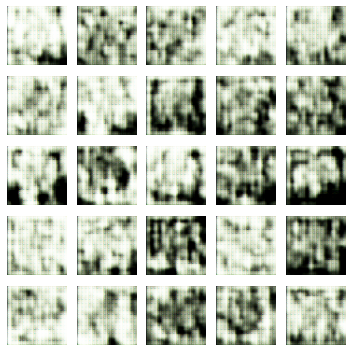

4/4 [==============================] - 0s 12ms/step
Epoch: 2 	 Discriminator Loss: 0.706398606300354 		 Generator Loss: 0.9500447511672974
4/4 [==============================] - 0s 12ms/step
Epoch: 3 	 Discriminator Loss: 0.6886754631996155 		 Generator Loss: 0.8322196006774902
4/4 [==============================] - 0s 12ms/step
Epoch: 4 	 Discriminator Loss: 0.6877045035362244 		 Generator Loss: 0.9518512487411499
4/4 [==============================] - 0s 12ms/step
Epoch: 5 	 Discriminator Loss: 0.6737819314002991 		 Generator Loss: 0.9501762390136719
4/4 [==============================] - 0s 12ms/step
Epoch: 6 	 Discriminator Loss: 0.6886885166168213 		 Generator Loss: 0.8253563642501831
4/4 [==============================] - 0s 12ms/step
Epoch: 7 	 Discriminator Loss: 0.6991788744926453 		 Generator Loss: 0.9056071639060974
4/4 [==============================] - 0s 13ms/step
Epoch: 8 	 Discriminator Loss: 0.6366918087005615 		 Generator Loss: 0.8963243961334229
4/4 [================

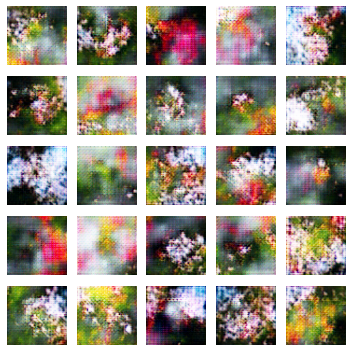

4/4 [==============================] - 0s 12ms/step
Epoch: 11 	 Discriminator Loss: 0.67610102891922 		 Generator Loss: 0.9547224044799805
4/4 [==============================] - 0s 12ms/step
Epoch: 12 	 Discriminator Loss: 0.6759644746780396 		 Generator Loss: 1.251130223274231
4/4 [==============================] - 0s 11ms/step
Epoch: 13 	 Discriminator Loss: 0.7247307896614075 		 Generator Loss: 1.2046542167663574
4/4 [==============================] - 0s 13ms/step
Epoch: 14 	 Discriminator Loss: 0.6605468392372131 		 Generator Loss: 0.8831115961074829
4/4 [==============================] - 0s 11ms/step
Epoch: 15 	 Discriminator Loss: 0.6574225425720215 		 Generator Loss: 0.8713818788528442
4/4 [==============================] - 0s 12ms/step
Epoch: 16 	 Discriminator Loss: 0.6770489811897278 		 Generator Loss: 0.8388879299163818
4/4 [==============================] - 0s 13ms/step
Epoch: 17 	 Discriminator Loss: 0.6691882610321045 		 Generator Loss: 0.8443052172660828
4/4 [===========

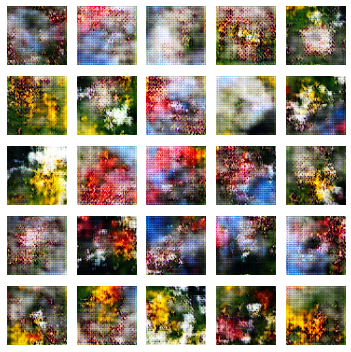

4/4 [==============================] - 0s 12ms/step
Epoch: 21 	 Discriminator Loss: 0.63319331407547 		 Generator Loss: 0.9763864874839783
4/4 [==============================] - 0s 13ms/step
Epoch: 22 	 Discriminator Loss: 0.6195741295814514 		 Generator Loss: 0.7888611555099487
4/4 [==============================] - 0s 14ms/step
Epoch: 23 	 Discriminator Loss: 0.6525797843933105 		 Generator Loss: 0.9762427806854248
4/4 [==============================] - 0s 12ms/step
Epoch: 24 	 Discriminator Loss: 0.6565995216369629 		 Generator Loss: 0.9126551151275635
4/4 [==============================] - 0s 12ms/step
Epoch: 25 	 Discriminator Loss: 0.6679990887641907 		 Generator Loss: 1.1113570928573608
4/4 [==============================] - 0s 12ms/step
Epoch: 26 	 Discriminator Loss: 0.6981701850891113 		 Generator Loss: 0.9436683058738708
4/4 [==============================] - 0s 13ms/step
Epoch: 27 	 Discriminator Loss: 0.709017813205719 		 Generator Loss: 0.8603646755218506
4/4 [===========

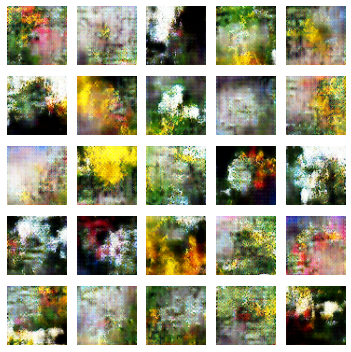

4/4 [==============================] - 0s 12ms/step
Epoch: 31 	 Discriminator Loss: 1.012930154800415 		 Generator Loss: 1.3385072946548462
4/4 [==============================] - 0s 15ms/step
Epoch: 32 	 Discriminator Loss: 0.6152405738830566 		 Generator Loss: 0.8613166213035583
4/4 [==============================] - 0s 14ms/step
Epoch: 33 	 Discriminator Loss: 0.6211599111557007 		 Generator Loss: 0.8420892953872681
4/4 [==============================] - 0s 12ms/step
Epoch: 34 	 Discriminator Loss: 0.6049008965492249 		 Generator Loss: 1.0793379545211792
4/4 [==============================] - 0s 14ms/step
Epoch: 35 	 Discriminator Loss: 0.6621618270874023 		 Generator Loss: 0.879062294960022
4/4 [==============================] - 0s 12ms/step
Epoch: 36 	 Discriminator Loss: 0.6226406097412109 		 Generator Loss: 1.414833664894104
4/4 [==============================] - 0s 11ms/step
Epoch: 37 	 Discriminator Loss: 0.5848580598831177 		 Generator Loss: 1.4121284484863281
4/4 [===========

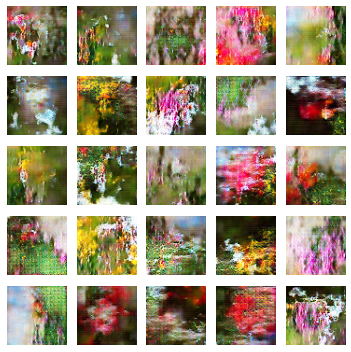

4/4 [==============================] - 0s 14ms/step
Epoch: 41 	 Discriminator Loss: 0.6034845113754272 		 Generator Loss: 0.993905246257782
4/4 [==============================] - 0s 12ms/step
Epoch: 42 	 Discriminator Loss: 0.628215491771698 		 Generator Loss: 1.275512456893921
4/4 [==============================] - 0s 12ms/step
Epoch: 43 	 Discriminator Loss: 0.7001296281814575 		 Generator Loss: 1.4169931411743164
4/4 [==============================] - 0s 13ms/step
Epoch: 44 	 Discriminator Loss: 0.6112219095230103 		 Generator Loss: 1.5362768173217773
4/4 [==============================] - 0s 12ms/step
Epoch: 45 	 Discriminator Loss: 0.5937937498092651 		 Generator Loss: 1.1315765380859375
4/4 [==============================] - 0s 22ms/step
Epoch: 46 	 Discriminator Loss: 0.5941390991210938 		 Generator Loss: 0.9551976919174194
4/4 [==============================] - 0s 12ms/step
Epoch: 47 	 Discriminator Loss: 0.6043339967727661 		 Generator Loss: 1.1155352592468262
4/4 [===========

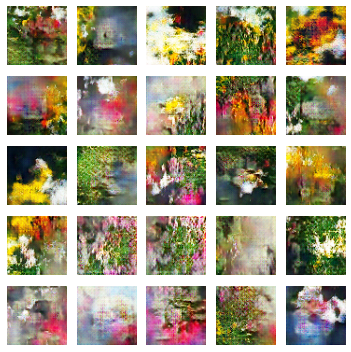

4/4 [==============================] - 0s 13ms/step
Epoch: 51 	 Discriminator Loss: 0.5667046904563904 		 Generator Loss: 1.1283807754516602
4/4 [==============================] - 0s 12ms/step
Epoch: 52 	 Discriminator Loss: 0.5961057543754578 		 Generator Loss: 1.3389770984649658
4/4 [==============================] - 0s 13ms/step
Epoch: 53 	 Discriminator Loss: 0.6242866516113281 		 Generator Loss: 1.3320050239562988
4/4 [==============================] - 0s 12ms/step
Epoch: 54 	 Discriminator Loss: 0.5238584876060486 		 Generator Loss: 1.4062511920928955
4/4 [==============================] - 0s 13ms/step
Epoch: 55 	 Discriminator Loss: 0.7279113531112671 		 Generator Loss: 0.8895046710968018
4/4 [==============================] - 0s 17ms/step
Epoch: 56 	 Discriminator Loss: 0.5450026988983154 		 Generator Loss: 1.425572395324707
4/4 [==============================] - 0s 12ms/step
Epoch: 57 	 Discriminator Loss: 0.6011419296264648 		 Generator Loss: 1.4360864162445068
4/4 [=========

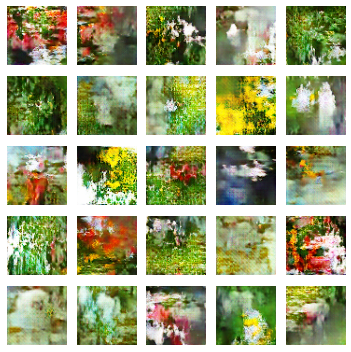

4/4 [==============================] - 0s 12ms/step
Epoch: 61 	 Discriminator Loss: 0.5792337656021118 		 Generator Loss: 1.4441683292388916
4/4 [==============================] - 0s 14ms/step
Epoch: 62 	 Discriminator Loss: 0.5771382451057434 		 Generator Loss: 1.5304911136627197
4/4 [==============================] - 0s 12ms/step
Epoch: 63 	 Discriminator Loss: 0.5293512940406799 		 Generator Loss: 1.398114800453186
4/4 [==============================] - 0s 12ms/step
Epoch: 64 	 Discriminator Loss: 0.5631219744682312 		 Generator Loss: 0.9760165214538574
4/4 [==============================] - 0s 12ms/step
Epoch: 65 	 Discriminator Loss: 0.5237845182418823 		 Generator Loss: 1.1508253812789917
4/4 [==============================] - 0s 14ms/step
Epoch: 66 	 Discriminator Loss: 0.6040579080581665 		 Generator Loss: 1.210004448890686
4/4 [==============================] - 0s 12ms/step
Epoch: 67 	 Discriminator Loss: 0.6181345582008362 		 Generator Loss: 1.74528968334198
4/4 [============

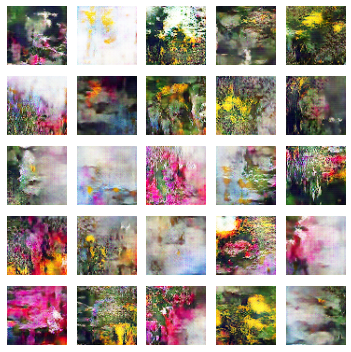

4/4 [==============================] - 0s 11ms/step
Epoch: 71 	 Discriminator Loss: 0.4678131937980652 		 Generator Loss: 1.0724701881408691
4/4 [==============================] - 0s 12ms/step
Epoch: 72 	 Discriminator Loss: 0.525523841381073 		 Generator Loss: 1.3336833715438843
4/4 [==============================] - 0s 15ms/step
Epoch: 73 	 Discriminator Loss: 0.5321570634841919 		 Generator Loss: 0.8907672762870789
4/4 [==============================] - 0s 14ms/step
Epoch: 74 	 Discriminator Loss: 0.4789706766605377 		 Generator Loss: 1.463619351387024
4/4 [==============================] - 0s 12ms/step
Epoch: 75 	 Discriminator Loss: 0.7070586681365967 		 Generator Loss: 0.8147108554840088
4/4 [==============================] - 0s 12ms/step
Epoch: 76 	 Discriminator Loss: 0.6474915146827698 		 Generator Loss: 1.984222412109375
4/4 [==============================] - 0s 23ms/step
Epoch: 77 	 Discriminator Loss: 0.455181747674942 		 Generator Loss: 2.4061970710754395
4/4 [============

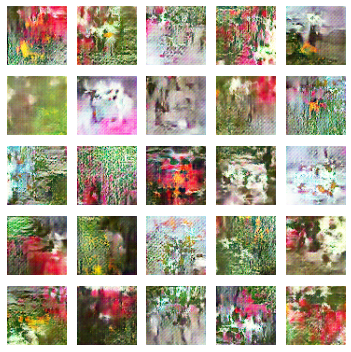

4/4 [==============================] - 0s 13ms/step
Epoch: 81 	 Discriminator Loss: 0.3075782060623169 		 Generator Loss: 2.811276912689209
4/4 [==============================] - 0s 13ms/step
Epoch: 82 	 Discriminator Loss: 0.33645549416542053 		 Generator Loss: 3.399667978286743
4/4 [==============================] - 0s 12ms/step
Epoch: 83 	 Discriminator Loss: 0.28159767389297485 		 Generator Loss: 3.7939603328704834
4/4 [==============================] - 0s 12ms/step
Epoch: 84 	 Discriminator Loss: 0.3361189365386963 		 Generator Loss: 2.892643928527832
4/4 [==============================] - 0s 12ms/step
Epoch: 85 	 Discriminator Loss: 0.6556932926177979 		 Generator Loss: 1.2682448625564575
4/4 [==============================] - 0s 12ms/step


In [ ]:
#-- Train ----------------------------------------------------------------------
d_losses = []
g_losses = []

STEPS_PER_EPOCH = int(X_train.shape[0]/BATCH_SIZE)+1
print(STEPS_PER_EPOCH)



for epoch in range(EPOCHS):
  for batch in range(STEPS_PER_EPOCH):
    
    #-- Create random vector --
    noise = np.random.normal(0, 1, size=(BATCH_SIZE, NOISE_VEC_DIM))

    #-- Generate fake images by generator --
    fake_x = generator.predict(noise)

    #-- Get real images
    real_x = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
    
    #-- Concat real images and fake images --
    x = np.concatenate((real_x, fake_x))
    
    #-- set true output for real images and fake images --
    disc_y = np.zeros(2*BATCH_SIZE)
    disc_y[:BATCH_SIZE] = 0.9

    #-- train discriminator --
    d_loss = discriminator.train_on_batch(x, disc_y)

    #-- set true output for generator --
    y_gen = np.ones(BATCH_SIZE)

    #-- train gan --
    g_loss = gan.train_on_batch(noise, y_gen)

    #-- Save Logs for tensorboard on each batch--    
    if batch==0 or (batch+1)%10==0:
      Write_Log_Loss(['g_loss'], [g_loss], batch)
      Write_Log_Loss(['d_loss'], [d_loss], batch)

  #-- save losses for each epoch--
  d_losses.append(d_loss)
  g_losses.append(g_loss)
    
  #-- Print losses for each epoch
  print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')

  #-- Plot Generead Images by Generator for each epoch --
  if epoch==0 or (epoch+1)%10==0:
    noise = np.random.normal(0, 1, size=(25, NOISE_VEC_DIM))
    Plot_Images(noise, (5, 5), generator, epoch) 

  #-- Save weights for each epoch --
  if epoch==0 or (epoch+1)%100==0 or (epoch+1)==EPOCHS:
    weights_file = 'gan_weights_{:04d}.h5'.format(epoch+1)
    gan.save_weights(weights_file)

  gc.collect()

Plot_Loss(d_losses, g_losses)